In [1]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from astropy.coordinates import SkyCoord
from galsim import InterpolatedImage, Image
from galsim import roman

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs, psf

In [2]:
lens = util.unpickle('/data/scratch/btwedig/mejiro/pipeline/02/lens_with_subhalos_00000000.pkl')
bands = ['F106']
grid_oversample = 5
exposure_time = 146

array, lens_surface_brightness, source_surface_brightness = lens.get_array(45 * grid_oversample, 4.95, bands[0],
                                                                           return_pieces=True)

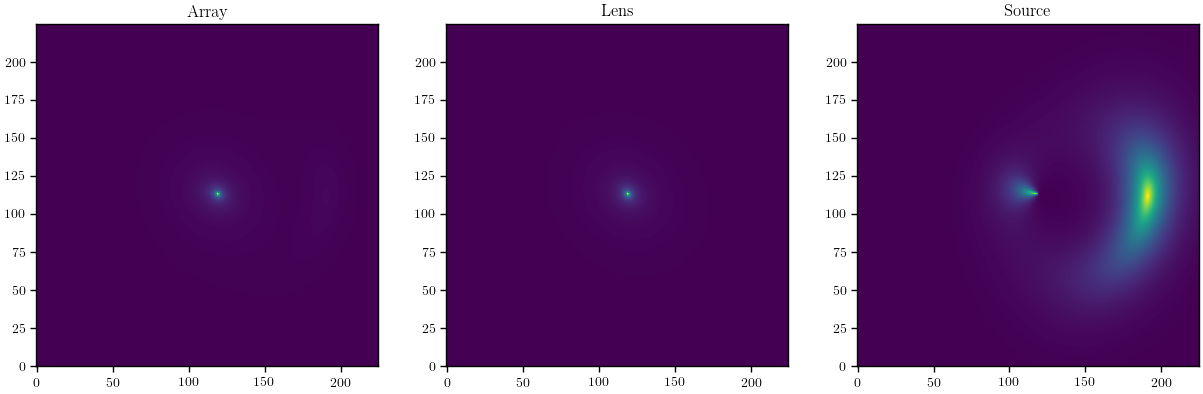

In [3]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(array)
ax[0].set_title('Array')
ax[1].imshow(lens_surface_brightness)
ax[1].set_title('Lens')
ax[2].imshow(source_surface_brightness)
ax[2].set_title('Source')
plt.show()

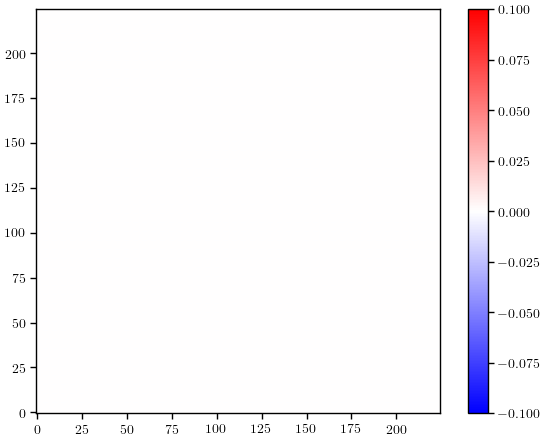

In [4]:
plt.imshow(array - (lens_surface_brightness + source_surface_brightness), cmap='bwr')
plt.colorbar()
plt.show()

In [5]:
# create galsim rng
rng = galsim.UniformDeviate(42)

In [6]:
os.environ['WEBBPSF_PATH'] = "/data/scratch/btwedig/STScI/ref_data/webbpsf-data"

In [7]:
# generate the PSFs I'll need for each unique band
psf_kernels = {}
for band in bands:
    psf_kernels[band] = psf.get_webbpsf_psf(band, 1, (2048, 2048), 5)
    # psf_kernels[band] = psf.get_galsim_psf(band, 1, (2048, 2048))

In [8]:
import datetime

wcs_dict = gs._get_wcs_dict(30, -30, datetime.datetime(year=2027, month=7, day=7, hour=0, minute=0, second=0))
bkgs = gs.get_sky_bkgs(wcs_dict, bands, 1, exposure_time, num_pix=45)

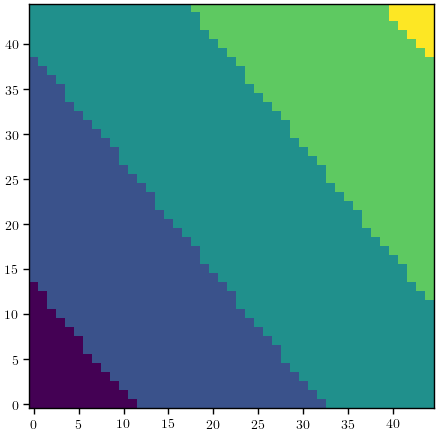

In [9]:
plt.imshow(bkgs[bands[0]].array)
plt.show()

In [10]:
results = []
for i, each in enumerate([array, lens_surface_brightness, source_surface_brightness]):
    # get flux
    if i == 0:
        flux = lens.get_total_flux_cps(bands[0])
        print(flux)
    elif i == 1:
        flux = lens.get_lens_flux_cps(bands[0])
        print(flux)
    elif i == 2:
        flux = lens.get_source_flux_cps(bands[0])
        print(flux)

    # get interpolated image
    interp = InterpolatedImage(Image(each, xmin=0, ymin=0), scale=0.11 / grid_oversample,
                               flux=flux * exposure_time)

    # get PSF
    psf_kernel = psf_kernels[band]

    # convolve image with PSF
    convolved = gs.convolve(interp, psf_kernel, 45)

    # add sky background to convolved image
    final_image = convolved + bkgs[band]

    # integer number of photons are being detected, so quantize
    final_image.quantize()

    # add all detector effects
    galsim.roman.allDetectorEffects(final_image, prev_exposures=(), rng=rng, exptime=exposure_time)

    # get the array
    final_array = final_image.array

    # center crop to get rid of edge effects (e.g., IPC)
    final_array = util.center_crop_image(final_array, (45, 45))

    # divide through by exposure time to get in units of counts/sec/pixel
    final_array /= exposure_time

    results.append(final_array)

4449.32926174296
4180.47165494026
268.8576068026999


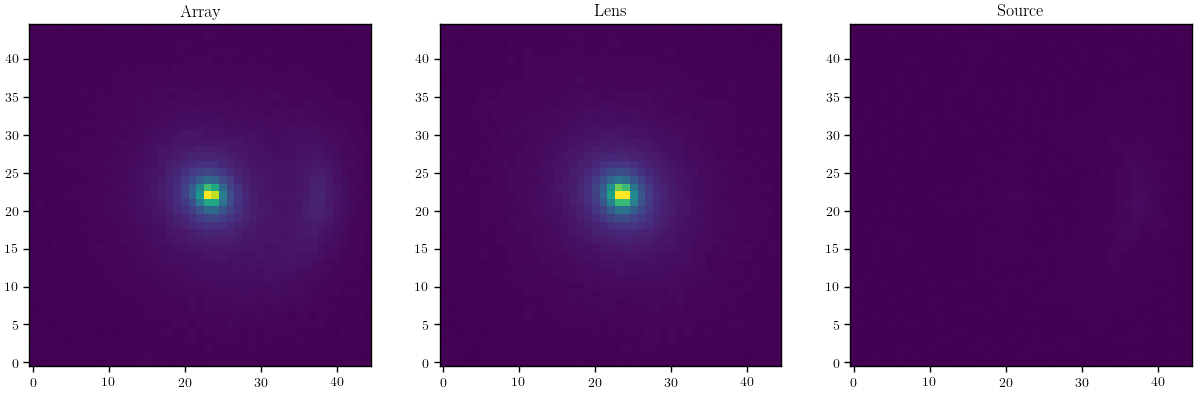

In [11]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
vmin = np.min(results[0])
vmax = np.max(results[0])
ax[0].imshow(results[0], vmin=vmin, vmax=vmax)
ax[0].set_title('Array')
ax[1].imshow(results[1], vmin=vmin, vmax=vmax)
ax[1].set_title('Lens')
ax[2].imshow(results[2], vmin=vmin, vmax=vmax)
ax[2].set_title('Source')
plt.show()

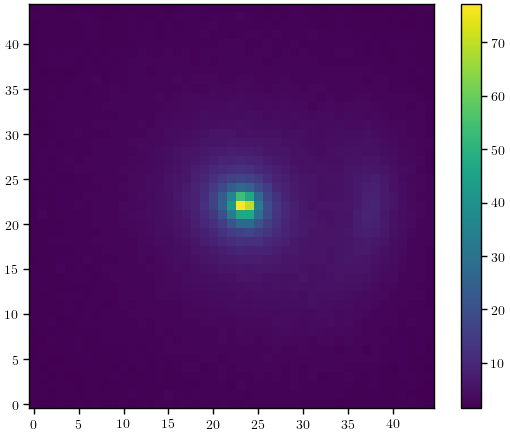

In [12]:
plt.imshow(results[0])
plt.colorbar()
plt.show()

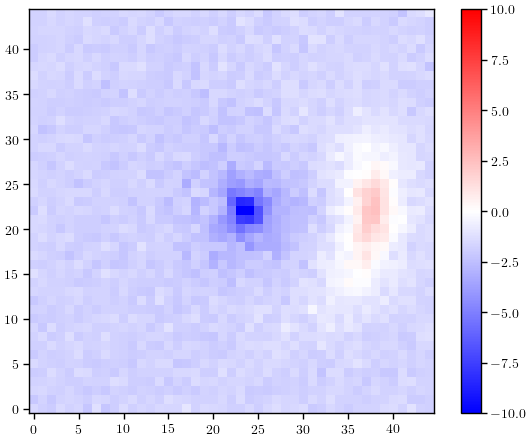

In [13]:
combined = results[1] + results[2]
v = plot_util.get_v([results[0], combined])
plt.imshow(results[0] - combined, cmap='bwr', vmin=-10, vmax=10)
plt.colorbar()
plt.show()

In [16]:
results, lenses, sources, execution_time = gs.get_images(lens, [array], bands, 45, 45, grid_oversample, grid_oversample,
                                                         lens_surface_brightness=[lens_surface_brightness],
                                                         source_surface_brightness=[source_surface_brightness],
                                                         detector=1, detector_pos=(2048, 2048), validate=False)

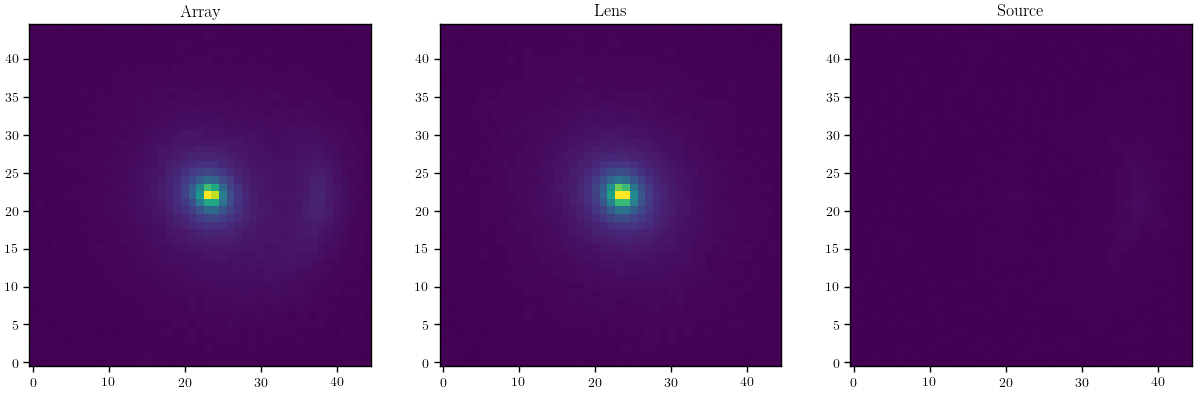

In [17]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
vmin = np.min(results[0])
vmax = np.max(results[0])
ax[0].imshow(results[0], vmin=vmin, vmax=vmax)
ax[0].set_title('Array')
ax[1].imshow(lenses[0], vmin=vmin, vmax=vmax)
ax[1].set_title('Lens')
ax[2].imshow(sources[0], vmin=vmin, vmax=vmax)
ax[2].set_title('Source')
plt.show()

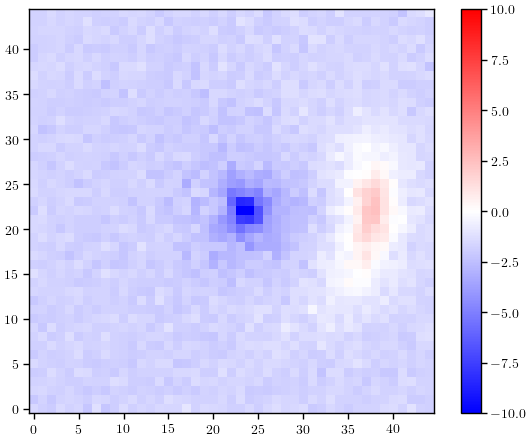

In [18]:
combined = lenses[0] + sources[0]
v = plot_util.get_v([results[0], combined])
plt.imshow(results[0] - combined, cmap='bwr', vmin=-10, vmax=10)
plt.colorbar()
plt.show()